In [108]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import re
import datetime as dt

# stats tests 
from scipy.stats import ttest_ind

In [2]:
# read in the data
data = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])

### Initial data cleaning 

In [3]:
# we see we have no missing values Nan's
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


In [4]:
# we see that in age we have a negative one. We will filter that out first. 
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [5]:
# filter out negative age
data = data[data.Age >=0]

In [6]:
# This turns the No-show variable into a binary of true or false where true means a no-show.  
data['no_show_bi'] = data["No-show"]== 'Yes'

In [7]:
# Create a column that is the day of the week of the appointment 
data["appointment_day"] = data["AppointmentDay"].dt.weekday_name

In [8]:
# Wednesday is the most common day of the week for an appointment, and Saturday is the least common. 
data["appointment_day"].value_counts()

Wednesday    25867
Tuesday      25640
Monday       22714
Friday       19019
Thursday     17247
Saturday        39
Name: appointment_day, dtype: int64

In [9]:
# Remove the Saturday appointments as they are clearly outliers. 
data= data[data["appointment_day"] != "Saturday"]

In [11]:
# create a column for the time between when a patient scheduled the appointment to the appointment.
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date)

In [12]:
# we see there are 5 appointments that seem to have a negative wait time. we will drop these next. 
data[data['wait'] < "0 days"]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,no_show_bi,appointment_day,wait
27033,7.839273e+12,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,True,Monday,-1 days
55226,7.896294e+12,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,True,Tuesday,-1 days
64175,2.425226e+13,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,True,Wednesday,-1 days
71533,9.982316e+14,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,True,Thursday,-6 days
72362,3.787482e+12,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,True,Tuesday,-1 days


In [13]:
# drop negative wait time rows. 
data = data[data['wait'] >= "0 days"]

In [14]:
# We see that a few neighbourhoods have very few appointments. 
# Neighboourhoods with less than 50 appointmnets are to be viewed as outliers. 
data.Neighbourhood.value_counts().tail(10)

UNIVERSITÁRIO                  152
SEGURANÇA DO LAR               145
NAZARETH                       135
MORADA DE CAMBURI               96
PONTAL DE CAMBURI               69
ILHA DO BOI                     35
ILHA DO FRADE                   10
AEROPORTO                        8
ILHAS OCEÂNICAS DE TRINDADE      2
PARQUE INDUSTRIAL                1
Name: Neighbourhood, dtype: int64

In [15]:
# remove outlier neighbourhoods
remove_list = ["ILHA DO BOI", "ILHA DO FRADE", "AEROPORTO", "ILHAS OCEÂNICAS DE TRINDADE","PARQUE INDUSTRIAL"]
data= data[~data.Neighbourhood.isin(remove_list)]

## Implement Binning System 
### Age Binning

In [61]:
def bin_age(df):
    '''Creates a function to turn age into 6 groups of binned ages.'''
                        # bin ranges 0-3, 4-7, 8-27, 28-40, 41-60, 61 < 
    if df["Age"] <4:
        return 2
    elif df["Age"] <8:
        return 5
    elif df["Age"] <28:
        return 16
    elif df["Age"] <41:
        return 34
    elif df["Age"] <61:
        return 51
    else:
        return 70
    

In [63]:
# apply binning function
data["Age_Binned"]= data.apply(bin_age, axis=1)

In [64]:
data["Age_Binned"].value_counts()

51    30052
16    26566
70    19732
34    19398
2      8943
5      5735
Name: Age_Binned, dtype: int64

#### Totals of the age bins.  
+ 8943 patients were 0-3 years of age. 
+ 5735 patients were 4-7 years of age. 
+ 26566 patients were 8-27 years of age. 
+ 19398 patients were 28-40 years of age. 
+ 19732 patients were 41-60 years of age. 
+ 30052 patients were 61+ years of age. 

### Wait time binning

In [121]:
# turn wait time from time delta to an int
data["days_waiting"] = data["wait"].dt.days

In [124]:
def bin_wait_time(df):
    '''Creates a function to turn wait_time into 5 groups of binned wait times .'''
                        # bin ranges 0, 1, 2-4, 5-9, 10 < 
    col="days_waiting"
    if df[col]   <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <5:
        return 3
    elif df[col] <10:
        return 7
    else:
        return 15

In [125]:
# Apply the binning function. 
data["Wait_Binned"]= data.apply(bin_wait_time, axis=1)

In [132]:
data.Wait_Binned.value_counts()

0     38536
15    35816
7     16145
3     14723
1      5206
Name: Wait_Binned, dtype: int64

### Totals of the waiting bins. 
+ 38536 patients had a wait of 0   days. 
+ 5206  patients had a wait of  1  day.
+ 14723 patients had a wait of 2-4 days.
+ 16145 patients had a wait of 5-9 days.
+ 35816 patients had a wait of 10+ days. 


## Some interesting observations

#### While we have the time the appointment was scheduled we do not have the time of the appointment. This seems to be less useful but perhaps it is this way for patient privacy. 

In [169]:
# The no-show rate is the mean of the no_show_bi column. 
#This will be used to compare the different features and how they relate to the no shows rate. 
data.no_show_bi.mean()

0.20191802655171789

### The total no-show rate for the data set is 20.19% This is the base rate to compare with specifics groups of patients. 
### We will now investigate the question following question: Which variables given appear to have a strong correlation to whether or not a patient will miss their appointment?

In [170]:
# The day of the week that the appointment happens slightly affects the no-show rate. 
data.groupby('appointment_day')[["no_show_bi"]].mean()

,no_show_bi
appointment_day,
Friday,0.212252
Monday,0.206509
Thursday,0.193582
Tuesday,0.200897
Wednesday,0.196860


#### Wednesday and Thursday have a lower no-show rate while Monday and Friday have a higher no-show rate. 

In [171]:
data.groupby('Gender')[["no_show_bi"]].mean()

,no_show_bi
Gender,
F,0.203093
M,0.199736


#### Comparing gender, females have a slightly higher rate of no show but this is probably an insignificant difference. 

## Compare Gender with all other variables. 

In [135]:
males=data[data.Gender == "M"]
females=data[data.Gender== "F"]
ttest_ind(males[["no_show_bi"]],females[["no_show_bi"]])
# No stats sig, correlation between gender and no-show

Ttest_indResult(statistic=array([-1.32532189]), pvalue=array([ 0.18506715]))

In [22]:
# STRONG SIG correlation between gender and receiving a text.. males average 29%, females 33.4% percent. 
ttest_ind(males[['SMS_received']],females[['SMS_received']])

Ttest_indResult(statistic=array([-15.39816186]), pvalue=array([  1.91413919e-53]))

In [23]:
males['SMS_received'].mean()

0.29162138384308856

In [24]:
females['SMS_received'].mean()

0.3369322931178601

In [25]:
# STRONG SIG correlation between gender and having a handicap. males average 2.7%, females 2% percent. 
ttest_ind(males[['Handcap']],females[['Handcap']])

Ttest_indResult(statistic=array([ 7.55852484]), pvalue=array([  4.10794206e-14]))

In [27]:
males['Handcap'].mean()

0.027247321844434094

In [28]:
females['Handcap'].mean()

0.0195458344942881

In [29]:
# strong sig correlation between gender and alcoholism, Males 5.5% and Females, 1.7% 
ttest_ind(males[['Alcoholism']],females[['Alcoholism']])

Ttest_indResult(statistic=array([ 35.50373422]), pvalue=array([  1.53774853e-274]))

In [30]:
males['Alcoholism'].mean()

0.055270920664493094

In [31]:
females['Alcoholism'].mean()

0.017024240735580943

In [32]:
# strong sig correlation between gender and Hipertension, Males-16.7% and Females-21.3% with Hipertension
ttest_ind(males[['Hipertension']],females[['Hipertension']])

Ttest_indResult(statistic=array([-18.53368299]), pvalue=array([  1.44429521e-76]))

In [33]:
males['Hipertension'].mean()

0.16700305335610413

In [34]:
females['Hipertension'].mean()

0.2134577876845918

In [35]:
# strong sig correlation between gender and Diabetes, Males -> 6% and Females -> 7.8% with Diabetes
ttest_ind(males[['Diabetes']],females[['Diabetes']])

Ttest_indResult(statistic=array([-10.83773613]), pvalue=array([  2.35398973e-27]))

In [36]:
males['Diabetes'].mean()

0.06036847280442995

In [37]:
females['Diabetes'].mean()

0.0780161604903873

In [41]:
# very very strong sig correlation between gender and Scholarship, Males -> 5.2% and Females -> 12.3% with Scholarship
ttest_ind(males[['Scholarship']],females[['Scholarship']])

Ttest_indResult(statistic=array([-38.2212633]), pvalue=array([ 0.]))

In [42]:
males['Scholarship'].mean()

0.051958805568493506

In [43]:
females['Scholarship'].mean()

0.12329339648927277

In [45]:
# very very strong sig correlation between gender and Scholarship, Males -> 33.7% and Females -> 38.9% with Scholarship
ttest_ind(males[['Age']],females[['Age']])

Ttest_indResult(statistic=array([-35.59631071]), pvalue=array([  5.92430325e-276]))

In [46]:
males['Age'].mean()

33.72395590746778

In [47]:
females['Age'].mean()

38.88496795764837

In [136]:
ttest_ind(males[['days_waiting']],females[['days_waiting']])

Ttest_indResult(statistic=array([-9.40889474]), pvalue=array([  5.10555325e-21]))

In [137]:
females['days_waiting'].mean()

10.504987461688492

In [139]:
np.std(females['days_waiting'])

15.479966297400214

In [138]:
males['days_waiting'].mean()

9.5995445841743

In [140]:
np.std(males['days_waiting'])

14.820316742050718

## STOP 

In [172]:
data.Handcap.value_counts()

0    108188
1      2039
2       183
3        13
4         3
Name: Handcap, dtype: int64

#### Only about 2% of all patients have any handicap. We do see below a correlation betweeen the number of handicaps to no-show rate.  

In [174]:
data.groupby('Handcap')[["no_show_bi"]].mean()

,no_show_bi
Handcap,
0,0.202351
1,0.178519
2,0.202186
3,0.230769
4,0.333333


In [173]:
data.groupby('SMS_received')[["no_show_bi"]].mean()

,no_show_bi
SMS_received,
0,0.166971
1,0.275814


####  We see a very strong correlation between receiving a SMS and not showing up. This is somewhat counter intuitive, unless recieving a text is something that patients opt into and thus there is selection bias towards patients that know they are more likely to miss their appointments. It certainly bears further investigation. 

In [175]:
data.groupby('Alcoholism')[["no_show_bi"]].mean()

,no_show_bi
Alcoholism,
0,0.201928
1,0.201608


####  Alcoholism does not seem to affect the no-show rate. This does seem to be a surprising result. 

In [16]:
data.groupby('Hipertension')[["no_show_bi"]].mean()

,no_show_bi
Hipertension,
0,0.209013
1,0.173035


#### Hipertension does seem to negatively correlate with the no-show rate, those with Hipertension were less likely to no-show. 

In [177]:
data.groupby('Diabetes')[["no_show_bi"]].mean()

,no_show_bi
Diabetes,
0,0.203614
1,0.180008


#### Diabetes does seem to negatively correlate with the no-show rate. Those with Diabetes were less likely to no-show. 

In [178]:
data.groupby('Scholarship')[["no_show_bi"]].mean()

,no_show_bi
Scholarship,
0,0.198046
1,0.237429


#### Being on scholarship, does seem to correlate with a higher no-show rate. 

In [179]:
# a sample of the no-show rate from 15 of the 76 remaining neighbourhoods.
data.groupby('Neighbourhood')[["no_show_bi"]].mean().head(13)

,no_show_bi
Neighbourhood,
ANDORINHAS,0.230327
ANTÔNIO HONÓRIO,0.184502
ARIOVALDO FAVALESSA,0.223827
BARRO VERMELHO,0.215130
BELA VISTA,0.201363
BENTO FERREIRA,0.224942
BOA VISTA,0.185897
BONFIM,0.198341
CARATOÍRA,0.229980


#### We can see from the above that of the 76 remaining neighbourhoods many show a higher no-show rate than average and many show a lower no-show rate than average. The minimun rate by neighbourhood is 0.15 and the max is 0.29.

## IMPORTANT FEATURES: So far we have fount some categorical features of our dataset that should be able to help predict whether or not a patient will no-show. The strongest indicators seem to be appointment day, handicap, hipertension, diabetes, scholarship, recieved a text reminder and neighbourhood. 

### We will now evaluate some continuous variables to see there effect on the no-show rate. And the trends they indicate in the data.

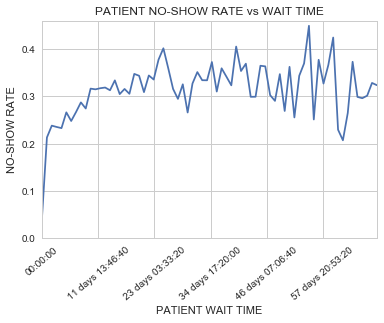

In [180]:
# create a plot of no-show rate by patient appointment wait time. 
data.groupby('wait').mean().no_show_bi[:70].plot()
plt.title("PATIENT NO-SHOW RATE vs WAIT TIME")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("PATIENT WAIT TIME")
plt.xticks(rotation=40)
plt.ylim(0,0.46)
plt.show()

#### From the above plot we can see that in general for the first 10 days of waiting the no-show rate increases. After this time the exact percent fluctuates but on average is rather consistant in the mid-thirties.

In [181]:
data.groupby('wait')[["no_show_bi"]].mean().head(5)

,no_show_bi
wait,
0 days,0.046476
1 days,0.213216
2 days,0.238223
3 days,0.235445
4 days,0.232967


#### We can clearly see above that no-shows for same day appointments is very low. 

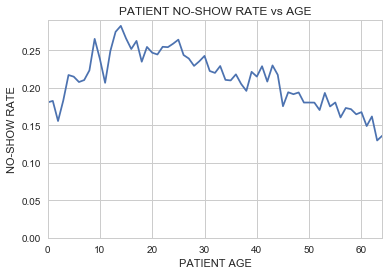

In [182]:
# create a plot of no-show rate compared to the patients age
data.groupby('Age').mean().no_show_bi[:65].plot()
plt.title("PATIENT NO-SHOW RATE vs AGE")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("PATIENT AGE")
plt.ylim(0,.29)
plt.show()

#### We can see that in general the no-show rate increases for patients age zero to around 20 years old and then slowly decreases as people get older.  

## TIME SERIES PLOTS

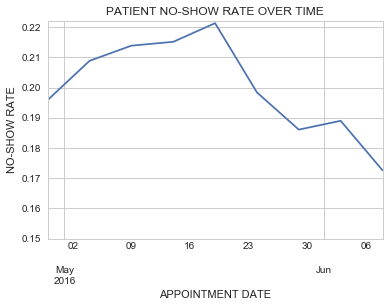

In [183]:
# create a plot of no-show rates over time. Here we are resampling by every five days to smooth out the graph. 
no_show_over_time = data.set_index('AppointmentDay').resample('5D').mean().no_show_bi.plot()
plt.title("PATIENT NO-SHOW RATE OVER TIME")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("APPOINTMENT DATE")
plt.ylim(0.15,.222)
plt.show()

#### The above graph shows that the average no-show rate increased until mid-May and then decreased. This is interesting and looking into why such a variation would exist could be enlightening.

In [184]:
data_by_month = data.set_index('AppointmentDay').resample('1M')[["no_show_bi"]].mean()
data_by_month

,no_show_bi
AppointmentDay,
2016-04-30,0.195605
2016-05-31,0.207851
2016-06-30,0.184569


#### The above shows that May on average had more no-shows than April or June. This is an odd observation, it would be interesting to see if something important occured external to this data that would cause such a shift by month. Also, it would be great if we had more of a timespan to investigate if this occurs on a yearly basis or month cycles.  

## In Conclusion, we have shown that many of the variables from this data set can be strong indicators of the likelihood of patient no-show to a doctors appointment. We found some variables like alcoholism and gender to be very incosequential where as receiving an SMS reminder is surprisingly very correlated no-show rate. 